In [1]:
!pip install wfdb
!pip install EMD-signal
!pip install antropy

# from google.colab import drive
# drive.mount('/content/drive')

# !ls '/content/drive/MyDrive/BSP Paper Implementation/mit-bih-arrhythmia-database-1.0.0'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
  Attempting uninstall: dill
    Found existing installation: dill 0.3.8
    Uninstalling dill-0.3.8:
      Successfully uninstalled dill-0.3.8
  Attempting uninstall: multiprocess
    Found existing installation: multiprocess 0.70.16
    Uninstalling multiprocess-0.70.16:
      Successfully uninstalled multiprocess-0.70.16
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.1.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.9 which

In [2]:
import os
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as sg
import antropy as ant
import csv

from numpy.linalg import svd
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from PyEMD import EMD, EEMD
# from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# Define the path to the dataset directory in your Google Drive
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'

In [3]:
# Define parameters

SEGMENT_SIZE = 300
TRAIN_SET_SIZE = 2000
TEST_SET_SIZE = 500

# EMD and EEMD parameters
EMD_IMFS = 3
EEMD_IMFS = 7

In [4]:
#### Function definitions

## Preprocessing

# Mean bias correction
def bias_correction(signal):
    return signal - np.mean(signal)

# Moving average filter
def MA_filter(signal, window_size=6):
    return np.convolve(signal, np.ones(window_size)/window_size, mode='valid')

# High pass filter
def HP_filter(signal, cutoff=1, fs=360, order=6):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='high', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # Apply filter
    return filtered_signal

# Low pass filter
def LP_filter(signal, cutoff=45, fs=360, order=5):
    nyquist = 0.5 * fs  # Nyquist frequency
    normal_cutoff = cutoff / nyquist  # Normalize the cutoff frequency
    b, a = sg.butter(order, normal_cutoff, btype='low', analog=False)  # Butterworth filter
    filtered_signal = sg.filtfilt(b, a, signal)  # forward backward filtering
    return filtered_signal

# Denoising
def denoise(signal):
    stage1 = bias_correction(signal)
    stage2 = MA_filter(stage1)
    stage3 = HP_filter(stage2)
    stage4 = LP_filter(stage3)
    return stage4

## Feature extraction

# Initializing EMD
emd = EMD(spline_kind = "cubic", std_thr = 0.3, total_power_thr = 0.0005, range_thr = 0.0001)

# Initializing EEMD
eemd = EEMD()

# Extracting the feature vector from a set of IMFs
def extract_features(IMFs):
    # Combine all features into a feature vector
    feature_vector = []
    column_names = []
    i = 0
    for imf in IMFs:
        i = i + 1

        # Perform SVD and extract singular value (SV)
        singular_value = svd(imf.reshape(-1, 1), compute_uv=False)[0]

        # Calculate Coefficient of Variation (CV)
        mean_imf = np.mean(imf)
        std_imf = np.std(imf)
        CV = (std_imf / mean_imf) ** 2

        # Calculate Sample Entropy (SEN)
        sampEn = ant.sample_entropy(imf)

        # Calculate Band Power (BP)
        bp_value = np.mean(np.square(imf))

        features = [sampEn, CV, singular_value, bp_value]
        columns = [f'SV {i}', f'CV {i}', f'SEN {i}', f'BP {i}']
        feature_vector = np.concatenate((feature_vector, features))
        column_names = np.concatenate((column_names, columns))
    column_names = np.concatenate((column_names, ["Class"]))
    return feature_vector, column_names

# Extracting features data fram from an input dataframe
def get_features_df(input_df, decompose):
    print("Started extracting features")
    all_features_df = pd.DataFrame()
    # print(all_features_df.shape)
    for i in range(input_df.shape[0]):
        X_i = input_df.iloc[i, :-1].to_numpy()
        y_i = input_df.iloc[i,-1]

        if (decompose == "eemd"):
            IMFs = eemd (X_i, max_imf = EEMD_IMFS)
            if (len(IMFs)>EEMD_IMFS):
                IMFs = IMFs[0:EEMD_IMFS]

        elif (decompose == "emd"):
            IMFs = emd(X_i, max_imf = EMD_IMFS)
            if (len(IMFs)>EMD_IMFS):
                IMFs = IMFs[0:EMD_IMFS]

        else:
            print(f"Error: Invalid decomposition method '{decompose}' provided")
            break
        if (i+1) % 100 == 0: print(f"Decomposed segment {i+1}", end='; ')

        features_i, column_names = extract_features(IMFs)
        if (i+1) % 100 == 0: print(f"Extracted features from segment {i+1}", end='; ')
        features_i = np.append(features_i, y_i)
        feature_df = pd.DataFrame([features_i], columns=column_names)
        if (i+1) % 100 == 0: print(f"Created a dataframe for segment {i+1}.")
        all_features_df = pd.concat([all_features_df, feature_df], ignore_index=True)

    print("Finished extracting features")
    print() # Print an empty space
    return all_features_df

In [5]:
path = '/kaggle/input/mitbit-arrhythmia-database/mitbih_database/'
window_size = 300
maximum_counting = 10000

classes = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classes)
count_classes = [0]*n_classes

X = list()
y = list()

# Read files from the dataset directory
filenames = next(os.walk(path))[2]
filenames.sort()

# Segregate filenames and annotations
records = []
annotations = []

for f in filenames:
    filename, file_extension = os.path.splitext(f)
    if file_extension == '.csv':
        records.append(path + filename + file_extension)
    else:
        annotations.append(path + filename + file_extension)

for r in range(0,len(records)):
    signals = []

    with open(records[r], 'rt') as csvfile:
        spamreader = csv.reader(csvfile, delimiter=',', quotechar='|') # read CSV file\
        row_index = -1

        for row in spamreader:
            if(row_index >= 0):
                signals.insert(row_index, int(row[1]))
            row_index += 1


    # Plot an example to the signals
    # if r == 1:
    #     # Plot each patient's signal
    #     plt.title(records[1] + " Wave")
    #     plt.plot(signals[0:700])
    #     plt.show()
        
    # can denoise here  
    signals = denoise(signals)

    
    # Read anotations: R position and Arrhythmia class
    example_beat_printed = False
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines() 
        beat = list()

        # Headers of annotation files
        # if r==0:
        #     print(data[0])


        for d in range(1, len(data)): # 0 index is Chart Head
            splitted = data[d].split(' ')
            splitted = filter(None, splitted)
            next(splitted) # Time... Clipping
            pos = int(next(splitted)) # Sample ID
            arrhythmia_type = next(splitted) # Type
            
            if(arrhythmia_type in classes):
                arrhythmia_index = classes.index(arrhythmia_type)
                
                if(window_size//2 <= pos and pos < (len(signals) - window_size//2)):
                    beat = signals[pos-window_size//2:pos+window_size//2]     ## REPLACE WITH R-PEAK DETECTION
                    # Plot an example to a beat    
                    # if r == 1 and not example_beat_printed: 
                    #     plt.title("A Beat from " + records[1] + " Wave")
                    #     plt.plot(beat)
                    #     plt.show()
                    #     example_beat_printed = True

                    X.append(beat)
                    y.append(arrhythmia_index)
                    count_classes[arrhythmia_index] += 1

# data shape
print(np.shape(X), np.shape(y))

(100017, 300) (100017,)


In [6]:

# # Segment size
# window_size = SEGMENT_SIZE

# # Define arrhythmia classes
# classes = ['N', 'V', 'A', 'L', 'R']  # Normal, Ventricular Premature (VP), Atrial Premature (AP), Left Bundle Branch Block (LBBB), Right Bundle Branch Block (RBBB)
# n_classes = len(classes)
# count_classes = [0] * n_classes

# # Initialize lists to store beats and labels
# X = list()
# y = list()

# # Fetch record files from the dataset directory
# filenames = next(os.walk(path))[2]
# filenames.sort()

# # Process each record and annotation
# for filename in filenames:
#     example_beat_printed = False
#     # Only process .dat files (the signal data files)
#     if filename.endswith('.dat'):
#         record_name = filename.split('.')[0]

#         # Read the record (signals) and annotations
#         if record_name == '114':  # MLII is channel 1 not 0
#             record = wfdb.rdrecord((path + record_name), channels=[1])
#         else:
#             record = wfdb.rdrecord((path + record_name), channels=[0])

#         annotation = wfdb.rdann(path + record_name, 'atr')

#         signals = record.p_signal[:, 0]  # Taking MLII
#         signals = denoise(signals)

#         # Process the annotations to extract beats
#         for i in range(len(annotation.sample)):
#             arrhythmia_type = annotation.symbol[i]

#             # Plot an example to the signals
#             if i == 1 and record_name == '101':
#                 # Plot each patient's signal
#                 plt.figure(figsize=(12, 3))
#                 plt.title(f"700 Datapoints From Record {record_name} Wave")
#                 plt.plot(signals[0:700])
#                 plt.grid(True)
#                 plt.show()

#             if arrhythmia_type in classes:
#                 arrhythmia_index = classes.index(arrhythmia_type)
#                 pos = annotation.sample[i]  # Position of the R-peak (sample index)

#                 # Ensure we don't go out of bounds when extracting the beat
#                 if window_size//2 <= pos < len(signals) - window_size//2:
#                     beat = signals[pos-window_size//2:pos+window_size//2]
#                     # beat = stats.zscore(beat)  # Z-score normalization
#                     beat = beat/ np.max(np.abs(beat)) # Normalization

#                     # Plot an example beat (once)
#                     if record_name == '101' and not example_beat_printed:
#                         print() # Print an empty space before figure
#                         plt.figure(figsize=(6, 3))
#                         plt.title(f"A Single Beat From Record {record_name} Wave")
#                         plt.plot(beat)
#                         plt.grid(True)
#                         plt.show()
#                         example_beat_printed = True

#                     X.append(beat)  # 300 point ECG vectors
#                     y.append(arrhythmia_index)  # Arrhythmia class labels
#                     count_classes[arrhythmia_index] += 1

# print() # Print an empty space
# print(np.shape(X), np.shape(y))
# print("Class distribution:", count_classes)

In [7]:
# Creating a data frame
X_df = pd.DataFrame(X)
X_df[len(X[0])] = y
X_df.shape

(100017, 301)

300
0    75016
1     8071
2     7255
4     7129
3     2546
Name: count, dtype: int64


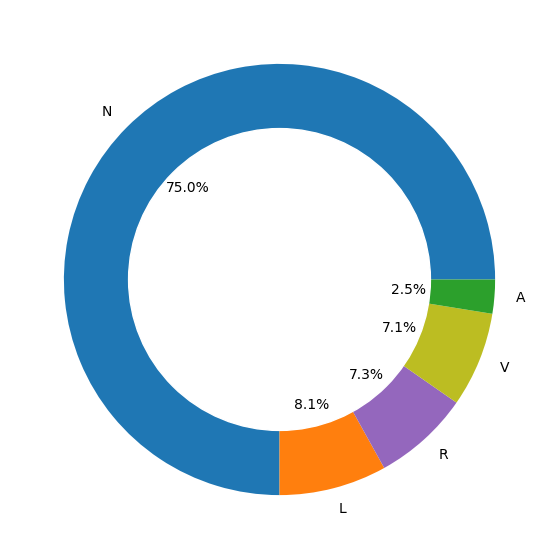

In [8]:
# Distribution of data
per_class = X_df[X_df.shape[1]-1].value_counts()
print(per_class)

plt.figure(figsize=(7,7))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['N', 'L', 'R', 'V', 'A'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [9]:
# Resampling the dataset to get to an even distribution
# TEST_SET_SIZE test data and TRAIN_SET_SIZE training data from each class
n_train = TRAIN_SET_SIZE
n_test = TEST_SET_SIZE
n_total = n_train + n_test

test_ratio = n_test/(n_total)

train = pd.DataFrame()
test = pd.DataFrame()

for class_value in range(5):

    # Filter the dataframe for the current class
    df_class = X_df[X_df[300] == class_value]

    # Randomly sample 2500 rows (or all rows if less )
    df_sampled_class = df_class.sample(n=min(n_total, len(df_class)), random_state=42)

    train_class, test_class = train_test_split(df_sampled_class, test_size= test_ratio)

    # Append the sampled rows to the new dataframe
    train = pd.concat([train, train_class])
    test = pd.concat([test, test_class])

# Reset index of the new dataframe
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

# Display the new dataframe
train.shape, test.shape

((10000, 301), (2500, 301))

In [10]:
per_class = train[train.shape[1]-1].value_counts()
print(per_class)

300
0    2000
1    2000
2    2000
3    2000
4    2000
Name: count, dtype: int64


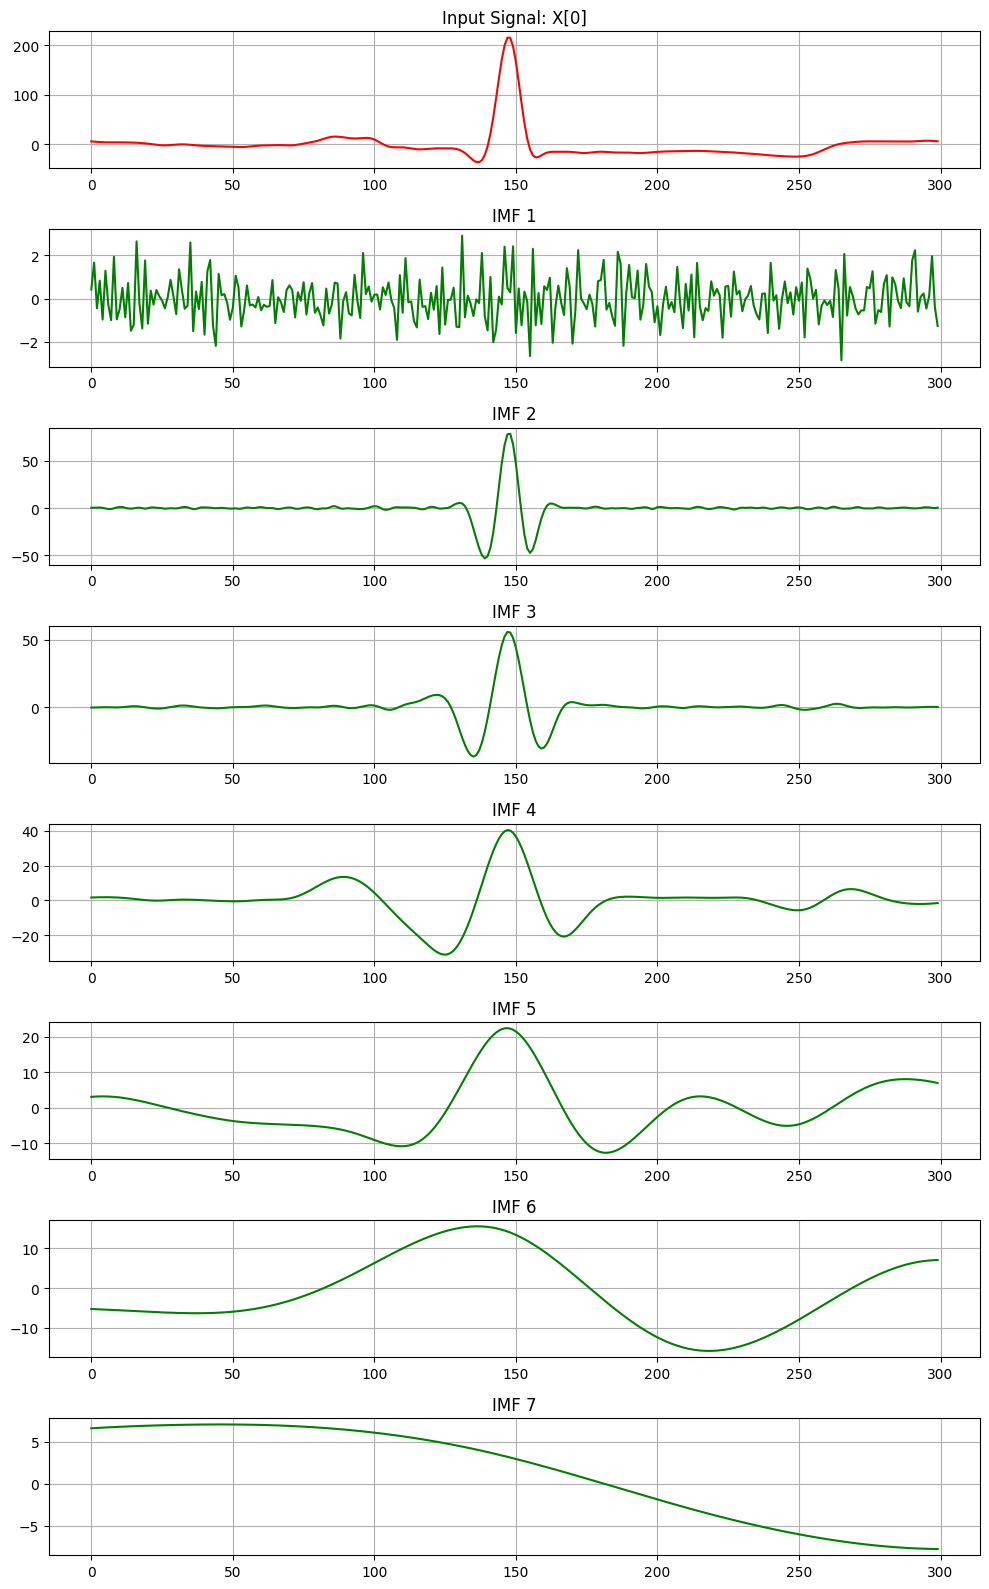

In [11]:
# Execute EEMD on signal
IMFs = eemd(X[0], max_imf=EEMD_IMFS)
N = IMFs.shape[0] # Number of subplots

plt.figure(figsize=(10, 2*N))  # Adjust the height based on the number of IMFs

# Plot the input signal
plt.subplot(N, 1, 1)
plt.plot(X[0], "r")
plt.title("Input Signal: X[0]")
plt.grid(True)

# Plot each IMF
for n, imf in enumerate(IMFs[:-1]):
    plt.subplot(N, 1, n + 2)
    plt.plot(imf, "g")
    plt.title(f"IMF {n + 1}")
    plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()

In [12]:
train_features_df_eemd = get_features_df(train, "eemd")
train_features_df_eemd.to_csv('/kaggle/working/train_feature_vector(EEMD).csv', index=False)


Started extracting features
Decomposed segment 100; Extracted features from segment 100; Created a dataframe for segment 100.
Decomposed segment 200; Extracted features from segment 200; Created a dataframe for segment 200.
Decomposed segment 300; Extracted features from segment 300; Created a dataframe for segment 300.
Decomposed segment 400; Extracted features from segment 400; Created a dataframe for segment 400.
Decomposed segment 500; Extracted features from segment 500; Created a dataframe for segment 500.
Decomposed segment 600; Extracted features from segment 600; Created a dataframe for segment 600.
Decomposed segment 700; Extracted features from segment 700; Created a dataframe for segment 700.
Decomposed segment 800; Extracted features from segment 800; Created a dataframe for segment 800.
Decomposed segment 900; Extracted features from segment 900; Created a dataframe for segment 900.
Decomposed segment 1000; Extracted features from segment 1000; Created a dataframe for seg

In [13]:
test_features_df_eemd = get_features_df(test, "eemd")
test_features_df_eemd.to_csv('/kaggle/working/test_feature_vector(EEMD).csv', index=False)

Started extracting features
Decomposed segment 100; Extracted features from segment 100; Created a dataframe for segment 100.
Decomposed segment 200; Extracted features from segment 200; Created a dataframe for segment 200.
Decomposed segment 300; Extracted features from segment 300; Created a dataframe for segment 300.
Decomposed segment 400; Extracted features from segment 400; Created a dataframe for segment 400.
Decomposed segment 500; Extracted features from segment 500; Created a dataframe for segment 500.
Decomposed segment 600; Extracted features from segment 600; Created a dataframe for segment 600.
Decomposed segment 700; Extracted features from segment 700; Created a dataframe for segment 700.
Decomposed segment 800; Extracted features from segment 800; Created a dataframe for segment 800.
Decomposed segment 900; Extracted features from segment 900; Created a dataframe for segment 900.
Decomposed segment 1000; Extracted features from segment 1000; Created a dataframe for seg

In [14]:
# print(train_features_df_eemd.shape)
# print(test_features_df_eemd.shape)

In [15]:
# train_features_df_eemd.tail()

In [16]:
# test_features_df_eemd.head()

In [17]:
# Remove rows where any cell has a NaN value
cleaned_train_df_eemd = train_features_df_eemd.dropna()
cleaned_train_df_eemd.to_csv('/kaggle/working/cleaned_train_df(EEMD).csv', index=False)


In [18]:
cleaned_test_df_eemd = test_features_df_eemd.dropna()
cleaned_test_df_eemd.to_csv('/kaggle/working/cleaned_test_df(EEMD).csv', index=False)

In [19]:
print(cleaned_train_df_eemd.shape)

(9985, 29)


In [20]:
print(cleaned_test_df_eemd.shape)

(2498, 29)


In [21]:
per_class_train = cleaned_train_df_eemd["Class"].value_counts()
print(per_class_train)

Class
1.0    2000
2.0    2000
0.0    1999
3.0    1999
4.0    1987
Name: count, dtype: int64


In [22]:
per_class_test = cleaned_test_df_eemd["Class"].value_counts()
print(per_class_test)

Class
0.0    500
1.0    500
2.0    500
3.0    500
4.0    498
Name: count, dtype: int64


In [23]:
# # Set the display options
# pd.set_option('display.max_rows', None)  # This line will allow all rows to be displayed.
# pd.set_option('display.max_columns', None)  # This line will allow all columns to be displayed.
# pd.set_option('display.width', None)  # This ensures that the display width is adjusted to show each line completely.

# # Create an empty DataFrame with specified columns
# columns = ['Features', 'Normal', 'PVC', 'APC', 'LBBB', 'RBBB']  # Example column names
# feature_stats = pd.DataFrame(index=range(EMD_IMFS*4), columns=columns)

# for class_label in range(5):  # Looping through classes 0 to 4
#     # Filter the dataframe for the current class
#     class_df = cleaned_train_df_eemd[cleaned_train_df_eemd['Class'] == class_label]
#     i = 0
#     for column in class_df.columns[:-1]:

#         # Calculate the median
#         median = class_df[column].median()

#         # Calculate Q1 and Q3
#         Q1 = class_df[column].quantile(0.25)
#         Q3 = class_df[column].quantile(0.75)

#         # Calculate IQR
#         IQR = Q3 - Q1

#         feature_stats.iat[i, 0] = column
#         feature_stats.iat[i, class_label+1] = f"{median:.5f} ± {IQR/2:.5f}"
#         i = i + 1

# feature_stats